Run the following cell to import the required packages:

In [52]:
from itertools import product
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

Let's return to the dog example from yesterday:

In [53]:
df = pd.read_csv("data/dogweights.csv")
df.head()

,weight,health status
0,50,1
1,50,1
2,52,1
3,50,1
4,48,0


Let's create our logistic regression model and calculate its score (which returns the mean accuracy on the given test data and labels). We see that out of 20 dogs, it classifies 85% correctly, meaning only 3 dogs got classified incorrectly:

In [54]:
X = df.drop(columns = ["health status"])
y = df["health status"]

model = LogisticRegression(solver="lbfgs")
model.fit(X, y)
print(model.score(X,y))

0.85


Let's visualize which ones may have gotten classified incorrectly. Don't focus on the code too much, just the picture:

/opt/anaconda3/envs/pyc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


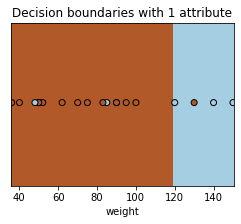

In [55]:
X = df.drop(columns = ["health status"])
Q = X
Q['dummy'] = 0
y = df["health status"]
h = .02  # meshsize
x_min, x_max = Q['weight'].min() - .5, Q['weight'].max() + .5 
y_min, y_max = Q['dummy'].min() - .5, Q['dummy'].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q['weight'], Q['dummy'], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 1 attribute')
plt.xlabel('weight')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.yticks(());

To see exactly which ones are misclassified, we can create a confusion matrix. We see that two unhealthy dogs were classfied incorrectly as healthy and one healthy dog was classified incorrectly as not healthy:

In [56]:
print(model.classes_)

model.fit(X, y)
confusion_matrix(y, model.predict(X))
#confusion_matrix(model.predict(X), y)

[0 1]


array([[ 3,  2],
       [ 1, 14]])

To view the matrix more clearly, we can use the following code (again, don't focus too much on the actual code):

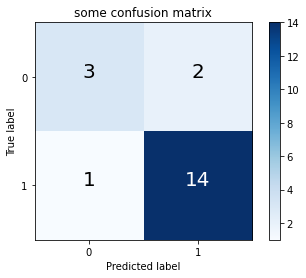

In [57]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm, classes=[0, 1], title='some confusion matrix',
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(confusion_matrix(y, model.predict(X)))

What are the actual model coefficients?

In [58]:
print(model.intercept_)
print(model.coef_)

[4.3727885]
[[-0.03673668  0.        ]]


This means that our model is given by:

$P(\text{dog is healthy}) = \frac{e^{4.373-0.0367(\text{weight})}}{1+e^{4.373-0.0367(\text{weight})}}$

What is the decision boundary separating from healthy and not healthy? Approximately 119 pounds, since 

$P(\text{dog is healthy}) = \frac{e^{4.373-0.0367(119)}}{1+e^{4.373-0.0367(199)}} \approx 50\%$

We can see this cutoff boundary by predicting a dog weighing 118 pounds and 120 pounds:

In [59]:
X = df.drop(columns = ["health status"])
y = df["health status"]

model = LogisticRegression(solver="lbfgs")
model.fit(X, y)

print(model.predict([[118]]))
print(model.predict([[120]]))

[1]
[0]


/opt/anaconda3/envs/pyc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pyc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Of course, we have violated the cardinal rule of machine learning which is that we didn't first break things up into a test/train split and only measure our success by the testing set accuracy. Let's do that now:

In [60]:
model = LogisticRegression(solver="lbfgs")

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(scores)
print('Accuracy: ', np.mean(scores))

[0.75 0.75 1.   0.75 0.75]
Accuracy:  0.8


Notice that in each testing set of 4 dogs, there was one dog that was misclassified except in the third iteration where all four dogs were classified correctly.

### The Iris Example
We'll do a Multinomial Logistic Regression now, in which we use the famous iris dataset to classify irises by their measurements as Iris Setosa, Iris Versicolour, Iris Virginica. Let's read the dataset in:

In [61]:
iris = load_iris()

X = pd.DataFrame(iris.data, columns = iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


The target variable is the categorical type of iris, where 0, 1, and 2 correspond to Iris Setosa, Iris Versicolour, and Iris Virginica, respectively.

In [62]:
y = iris.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let's create our logistic regression model and calculate its score (which returns the mean accuracy on the given test data and labels). We see that out of 150 irises, it classifies 96% correctly, meaning only 4 irises got classified incorrectly:

In [63]:
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=1000)

model.fit(X, y)

print(model.score(X,y))

0.9733333333333334


What is the actual model?

In [64]:
print(model.intercept_)
print(model.coef_)

[  9.84984798   2.23692223 -12.08677021]
[[-0.42354204  0.9673748  -2.51718519 -1.07940405]
 [ 0.5345048  -0.32156595 -0.20635727 -0.94439435]
 [-0.11096276 -0.64580885  2.72354246  2.02379841]]


This means that our model is given by:

$P(\text{Iris Setosa}) = \frac{e^{9.8549-0.424(\text{s length})+0.966(\text{s width})-2.517(\text{p length})-1.079(\text{p width})}}{1+e^{9.8549-0.424(\text{s length})+0.966(\text{s width})-2.517(\text{p length})-1.079(\text{p width})}}$


$P(\text{Iris Versicolour}) = \frac{e^{2.233+0.535(\text{s length})-0.32(\text{s width})-0.206(\text{p length})-0.94(\text{p width})}}{1+e^{2.233+0.535(\text{s length})-0.32(\text{s width})-0.206(\text{p length})-0.94(\text{p width})}}$


$P(\text{Iris Virginica}) = \frac{e^{-12.088-0.11(\text{s length})-0.645(\text{s width})+2.723(\text{p length})+2.023(\text{p width})}}{1+e^{-12.088-0.11(\text{s length})-0.645(\text{s width})+2.723(\text{p length})+2.023(\text{p width})}}$


Let's see how this works in practice. The first iris in our training set has these properties and our model predicts it be Class 0 (the Iris Setosa).

In [65]:
print(X.iloc[0])
print('\n predicton:', model.predict([X.iloc[0]]))

sepal length (cm)    5.1
sepal width (cm)     3.5
petal length (cm)    1.4
petal width (cm)     0.2
Name: 0, dtype: float64

 predicton: [0]


/opt/anaconda3/envs/pyc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


If we plug this iris' properties into the three regression models above, we see that the largest probability is the first one, the iris setosa. Therefore, this data point gets classified as an iris setosa:

In [66]:
def prob_function(intercept, coeff, X):
    term = np.exp(intercept+X[0]*coeff[0]+X[1]*coeff[1]+X[2]*coeff[2]+X[3]*coeff[3])
    return term/(1+term)

print(prob_function(model.intercept_[0], model.coef_[0], X.iloc[0]))
print(prob_function(model.intercept_[1], model.coef_[1], X.iloc[0]))
print(prob_function(model.intercept_[2], model.coef_[2], X.iloc[0]))

0.9993485480817506
0.96641899341338
2.2650813141551032e-05


We can't visualize in 2D exactly which 4 got classified incorrectly, because there are four explanatory variables. However, we can make a good guess of which might be those 4 if we visualize the decision boundary between just sepal width and width. Don't pay too much attention to the code, just view the picture:

/opt/anaconda3/envs/pyc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(1.5, 4.900000000000003)

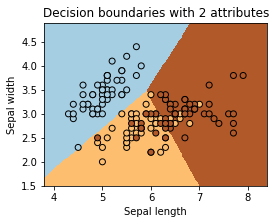

In [67]:
# Plot the decision boundary in 2-d 
# For that, we will assign a color to each point in the 
# mesh [x_min, x_max] x [y_min, y_max].

Q = X.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

To see exactly which ones were mislabeled, we can view a confusion matrix. We can see that three Iris Versicolours were incorrectly mislabeled as Iris Virginica and one Iris Virginica was incorrectly mislabeled as a Iris Versicolours.

In [69]:
model.fit(X, y)
confusion_matrix(y, model.predict(X))

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]])

Of course, we've violated one of the biggest rules in all of machine learning which is to evaluate our accuracy on the test data not the training set. So let's first do a test/train split and then view the confusion matrix of the testing data:

train_score=0.9714285714285714
test_score=0.9777777777777777


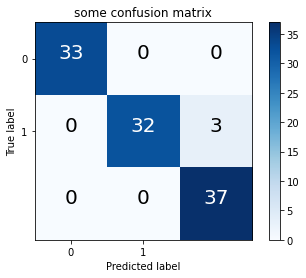

In [ ]:
# Split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=1000)

model.fit(X_train, y_train)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print(f"train_score={acc_train}")
print(f"test_score={acc_test}")

plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)))

### Logistic Regression - Digit example
Another famous dataset used as an example for classifications is the digit dataset. Let's load it in the data. If you'd like to read the descriptions of what the data is, you can uncomment the two print statements below:

In [ ]:
digits = load_digits()
# print(digits.DESCR)
# print(load_digits.__doc__)

There are 1797 images in the dataset. Since each image is 8 pixels wide by 8 pixels high, there are 64 attributes for each image. Each attribute takes on an integer value from 0 through 16, indicating black to white. Using these 64 numerical attributes, we'd like to predict the category (i.e., is the digit 0, 1, 2, ..., or 9)? Let's view one of the images' numerical data:

In [ ]:
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


And its corresponding image:

<Figure size 432x288 with 0 Axes>

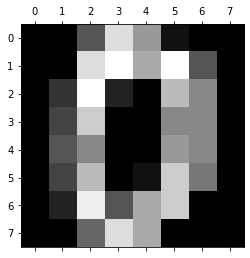

In [ ]:
plt.gray()
plt.matshow(digits.images[0])

Let's view the digits 0 through 4:

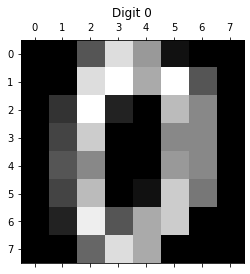

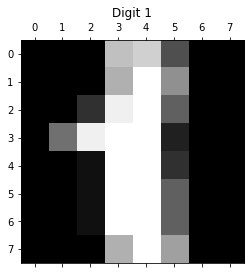

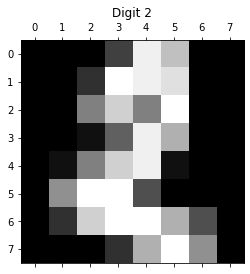

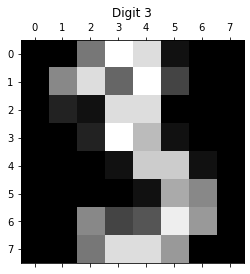

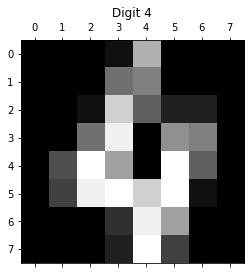

In [ ]:
for i in range(5):
    image = digits.images[i]
    digitname = digits.target[i]
    plt.matshow(image)
    plt.title("Digit %s" % digitname)

Let's use Logistic Regression to predict the digits:

In [ ]:
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)


model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)

print('train accuracy ', model.score(X_train, y_train))
print('test accuracy', model.score(X_test,y_test))

train accuracy  1.0
test accuracy 0.9611111111111111


We can see from the confusion matrix below that out of all the 1's, for example, one was incorrectly labeled as a 2 and one was incorrectly labeled as a 3. Out of the 8's, one each were mislabeled as a 1, 5, 6, 9.

In [ ]:
confusion_matrix(y, model.predict(X))

array([[176,   0,   0,   0,   0,   1,   0,   1,   0,   0],
       [  0, 180,   1,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 175,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 183,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0, 178,   0,   0,   1,   1,   0],
       [  0,   0,   0,   0,   0, 180,   1,   0,   0,   1],
       [  0,   1,   0,   0,   0,   0, 180,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0, 178,   0,   0],
       [  0,   1,   0,   0,   0,   1,   1,   0, 170,   1],
       [  0,   0,   0,   1,   0,   2,   0,   0,   1, 176]])